In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy.stats as st
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

from sklearn.manifold import TSNE
import plotly.graph_objects as go
import random
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
from nltk.corpus import stopwords

from gensim.models import CoherenceModel

import spacy

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

# What is the recipe for the perfect movie in **BOLLYWOOD** vs. in **HOLLYWOOD**?

# Data loading

With the loading, we do a simple pre-processing work where we remove punctuation and capitalization from words

### Movie metadata
This dataset contains the basics informations of differents movies. Here, you have the name of the differents informations and their definition.

| Column name          | Description                                                                                                                                                                                       |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| wikipedia_movie_id | ID of the movie from wikipedia                                                                                                                                                 |
| freebase_movie_id| ID of the movie from freebas                                                                                                                                            |
| movie_name | Name of the movie                                                                                                                                                |
| movie_release_date  | Date the movie was released                                                                                                                                      |
| movie_box_office_revenue  | Revenue of the movie box office                                                                                                                           
| movie_runtime  | Run time of the movie                                                                                                                                                 |
| movie_languages | Languages of the movie                                                                                                                                                  |
| movie_countries | Countries where the movie were created                                                                                                                                  |   |   |   |
| movie_genres   | Genre of the movie                                                                                                                                              |




In [ ]:
data_folder = './data/'

names = ['wikipedia_movie_id','freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 
        'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

movies_data = pd.read_csv(data_folder + 'movie.metadata.tsv', names = names, sep = '\t', )

movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']]= movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda x: str.lower(x))

#character that we delete
#note: we don't delete ',' because we use it to split our columns
spec_char = ['{', '}', '"', ':']

for char in spec_char:
        movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].replace(char, '', regex = True)
#removing the reference where we already have the info we need
movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda s: re.sub('\B\/\w+', '',s))
movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda s: re.sub('\B\/\w+', '',s))
movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda s: s.strip())
movies_data.head()

In [ ]:
movies_data.info()

As we can see above, the dataset is complete except for the categories move_box_office_revenue that are often unavailable and the movie_runtime.

To complete our data, we will use the title.ratings.tsv.gz and title.basics.tsv.gz datasets from IMDb that contain respectivly the ratings  and informations (like the runtime) about them


### IMdb datasets (ratings, runtimes, isAdult)

In [ ]:
ratings = pd.read_csv(data_folder + 'title.ratings.tsv.gz', sep='\t', compression='gzip')
titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')

In [ ]:
#merging IMdb dataset with title, isAdult and runtimeMinutes with dataset with averageRating on movie ID (tconst)
rates = titles.merge(ratings, how='left', on='tconst')[['averageRating', 'numVotes', 'originalTitle', 'isAdult', 'runtimeMinutes']]

#putting all titles to lower case to match the CMU dataset movie names and dropping column with upper cases
rates['movie_name'] = [ele.lower() for ele in rates['originalTitle'].astype(str)]
rates=rates.drop(columns='originalTitle')

#dropping all rows that have a movie name appearing multiple times so the merging on movie name with the CMU dataset is precise
rates = rates.drop_duplicates('movie_name', keep=False)

#converting runtimeMinutes to float and changing '\\N' to NaN to match the format in CMU dataset
rates['runtimeMinutes']=list(map(lambda x: float(x) if x!='\\N' else None , rates['runtimeMinutes']))

In [ ]:
#merging CMU dataset with the IMdb dataset
movies_data_merged = movies_data.merge(rates, how = 'left', on='movie_name')

#completing the NaN values in movie_runtime of the CMU dataset with the available ones of the IMdb dataset.
#we trust more the CMU dataset than the IMdb one so we give priority to the runtime values of the CMU dataset
# to the IMdb ones and use the IMdb only if the value is missing in the CMU.
#finally we drop the column with the IMdb runtimes.
movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'movie_runtime']=movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'runtimeMinutes']
movies_data_merged=movies_data_merged.drop(columns='runtimeMinutes')
movies_data_merged.head()

For further analysis, as we want to analyze indian and american movies, we will select the films that are only form both countries and separate in two dataframe.

In [ ]:
movies_indian = movies_data_merged[movies_data_merged['movie_countries'] == 'india'].reset_index()
movies_american = movies_data_merged[movies_data_merged['movie_countries'] == 'united states of america'].reset_index()

In [ ]:
movies_american.head()

In [ ]:
movies_indian.head()

In [ ]:
print('There are %d indian films and %d american films in the dataset' % (len(movies_indian), len(movies_american)))

### Film summaries dataset

In [ ]:
summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\r', names = ['summaries'])
summaries = summaries['summaries'].str.split("\t", expand = True)
summaries = summaries.rename(columns= {0:'wikipedia_movie_id',1: 'summaries'})
summaries['summaries'] = summaries['summaries'].str.lower()
summaries['wikipedia_movie_id'] = summaries['wikipedia_movie_id'].astype(int)
summaries.head()

### Characters metadata


| Column name          | Description                                                                                                                                                                                       |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| wikipedia_movie_id | ID of the movie from wikipedia                                                                                                                                                 |
| freebase_movie_id| ID of the movie from freebase                                                                                                                                            |
| movie_release_date | Date the movie was released                                                                                                                                                |
| character_name  | Name of the character played                                                                                                                        
| actor_dob  | Date of birth of the actor                                                                                                                                                 |
| actor_gender | Actor gender (F or M)                                                                                                                                                  |
| actor_height | Actor height (in [m])                                                                                                                                  |   |   |   |
| actor_ethnicity   | Actor ethnicity (in freebase ID)                                                                                                                                             |
| actor_name | Actor name                                                                                                                                                 |
| actor_age_at_movie_release | Age of the actor at the movie release                                                                                                                                                 |
| char_act_id | Actor ID                                                                                                                                                 |
| freebase_character_id | ID of the character from freebase                                                                                                                                                  |
| freebase_actor_id | ID of the actor from freebase                                                                                                                                                 |

In [ ]:
names = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'char_act_id', 'freebase_character_id', 'freebase_actor_id']
characters_data = pd.read_csv(data_folder + 'character.metadata.tsv', names = names, sep = '\t')
characters_data[['character_name', 'actor_name']] = characters_data[['character_name', 'actor_name']].applymap(lambda x: x if type(x)!=str else x.lower())
characters_data.head()

In [ ]:
characters_data.info()

### Including ethnicities

Using the automatic query system from wikidata, we are able to retrieve the ethnicity of the actors based on the freebase ID in the actor_ethnicity column. For that we just map the matching id to the string-representation of the ethnicity for clarity

In [ ]:
actor_ethnicities = pd.read_csv('data/ethnicities.csv')[['freebaseID', 'name']]
actor_ethnicities = dict(zip(actor_ethnicities.freebaseID, actor_ethnicities.name))
characters_data['actor_ethnicity'] = characters_data['actor_ethnicity'].map(actor_ethnicities)

# First analysis of difference between India and America

### Numbers of Indian vs American movies per year

In [ ]:
movies_years_indian = movies_indian.copy()

#slice the movie release date column to only have the years, and transform them as integer again
movies_years_indian['movie_release_date'] = movies_indian['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for indian movies
n_movie_per_year_indian = movies_years_indian.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_indian = pd.DataFrame(n_movie_per_year_indian).reset_index()

#sort the values
n_movie_per_year_indian['movie_release_date'] = n_movie_per_year_indian['movie_release_date'].sort_values()

n_movie_per_year_indian

In [ ]:
movies_years_american = movies_american.copy()

#slice the movie release date column to only have the years, and transform them as integer again
movies_years_american['movie_release_date'] = movies_years_american['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for american movies
n_movie_per_year_american = movies_years_american.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_american = pd.DataFrame(n_movie_per_year_american).reset_index()

#sort the values
n_movie_per_year_american['movie_release_date'] = n_movie_per_year_american['movie_release_date'].sort_values()

n_movie_per_year_american

Let us slice the data to have the same time frame: from 1912 to 2014 for both Indian and American movies.

In [ ]:
#Slice the data to have same time frame for both Indian and American movies data sets
n_movie_per_year_american = n_movie_per_year_american.query('movie_release_date <= 2014 & movie_release_date >= 1912')

In [ ]:
#Plot both Indian and American numbers of movies per year
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian')
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american')
plt.title('Indian vs American movies per year ')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.show()

We can observe a peak starting to grow from the 2000 years for both Hollywood and Bollywood movies.

In [ ]:
#Zoom in during the peak of Indian and American released movie years
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian')
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american')
plt.title('Indian vs American movies per year, from the 2000s')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.axis([2000, 2014, 0, 1000])
plt.show()

The peak of released movies are at 2006 for Hollywood and 2008 Bollywood respectively.

At 2014 it goes back to nearly 0 films released, but we should investigate carefully the data set that explain this lack of data.

Thus we begin the data set in 1950 for both Hollywood and Bollywood movies and cut the data set to 2006 for both Hollywood and Bollywood movies.


In [ ]:
# transform the movie release date column to only have the years, and transform them as integer again
movies_indian['movie_release_date'] = movies_indian['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')
movies_american['movie_release_date'] = movies_american['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

# Cut the data from 1950 to 2010 to have the same time frame for both Indian and American movies data sets
cut_movies_american = movies_american.query('movie_release_date <= 2010 & movie_release_date >= 1980')
cut_movies_indian = movies_indian.query('movie_release_date <= 2010 & movie_release_date >= 1980')

## Movie runtime

In [ ]:
print('%.3f percent of indian movies have a runtime and %.3f percent of american movies have a runtime' %
(100-np.sum(cut_movies_indian['movie_runtime'].isna())/cut_movies_indian.shape[0]*100, 100-np.sum(cut_movies_american['movie_runtime'].isna())/cut_movies_american.shape[0]*100))

print('Average runtime of indian movies : %.3f \tAverage runtime of american movies : %.3f' %
(cut_movies_indian['movie_runtime'].mean(), cut_movies_american['movie_runtime'].mean()))


### Distribution of movie runtimes

In [ ]:
data_runtime = pd.DataFrame({'USA': cut_movies_american.query('movie_runtime < 10000')['movie_runtime'], 'India': cut_movies_indian.query('movie_runtime < 10000')['movie_runtime']})
sns.histplot(data = data_runtime)
plt.yscale('log')
plt.legend(labels=["American movies","Indian movies"])
plt.title(f'Distribution of runtimes (outlier of removed)')
plt.show()

From this plot we can see that we have a few outliers in both datasets. Looking at most of the films that are longer than 1000 minutes (16 hours), we decided that they could be discarted as they are either errors or not pertinent to our analysis (series of films instead of single film).

In [ ]:
print('Number of films longer than 16 hours:', len(cut_movies_indian.query('movie_runtime > 1000')) + len(cut_movies_american.query('movie_runtime > 1000')))

Deleting 8 films that are very likely to be errors shouldn't make default to our analysis

In [ ]:
#defining number of bins to get roughly equal width between the 2 histograms
data_runtime = pd.DataFrame({'USA': cut_movies_american['movie_runtime'], 'India': cut_movies_indian['movie_runtime']})
#plotting
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
sns.histplot(cut_movies_american['movie_runtime'], alpha =.5, stat = 'density', bins = 100, binrange= [0,1000])
sns.histplot(cut_movies_indian['movie_runtime'], alpha=.5, color = 'orange', stat = 'density', bins = 100, binrange= [0,1000])
plt.yscale('log')
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Movie runtime')
plt.title('Movie runtime, differenciated by movie coutry')


plt.subplot(2,2,2)
sns.violinplot(data = data_runtime)
plt.ylabel('Minutes')
plt.title(f'Distribution of runtimes (outlier of removed)')

plt.show()

In [ ]:
print('median runtime difference:', np.nanmedian(cut_movies_american['movie_runtime'] - cut_movies_indian['movie_runtime']))

## Ratings

### Some global informations

In [ ]:
print('%.3f percent of indian movies have a rating and %.3f percent of american movies have a rating' %
(100-np.sum(cut_movies_indian['averageRating'].isna())/cut_movies_indian.shape[0]*100, 100-np.sum(cut_movies_american['averageRating'].isna())/cut_movies_american.shape[0]*100))

print('Average rating of indian movies : %.3f \tAverage rating of american movies : %.3f' %
(np.mean(cut_movies_indian['averageRating']), np.mean(cut_movies_american['averageRating'])))

### Distributions of movie ratings

In [ ]:
plt.figure(figsize=(7,3))
sns.histplot(x='averageRating', data=cut_movies_american, alpha=0.5, label='American', stat = 'density', binrange=[0,10], bins = 20, kde=True)
sns.histplot(x='averageRating', data=cut_movies_indian, alpha=0.5, color='orange', stat = 'density', label='Indian', binrange=[0,10], bins = 20, kde=True)
plt.title('Distribution of movies ratings')
plt.legend()
plt.show()

In [ ]:
print('P-value for normality test of american ratings : %.10f \tP-value for normality test of indian ratings : %.10f ' 
      % (st.normaltest(cut_movies_american['averageRating'], nan_policy='omit').pvalue, st.normaltest(cut_movies_indian['averageRating'], nan_policy='omit').pvalue))

Indian and american movies get similar distributions of ratings. This will allow us to use more easily the ratings as an unbiased tool to estimate the success of a movie.

### Distribution of number of votes

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.histplot(cut_movies_american['numVotes'], bins=np.logspace(0,7,50), alpha =.5, binrange=[0., 1e7], stat = 'density')
sns.histplot(cut_movies_indian['numVotes'], bins=np.logspace(0,7,50), alpha=.5, binrange=[0., 1e7], color = 'orange', stat = 'density')
plt.legend(labels=["American movies","Indian movies"])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of votes')
plt.title('Number of votes per film, differenciated by movie coutry')

plt.subplot(2,2,2)
sns.boxplot(data = pd.DataFrame({'USA': cut_movies_american['numVotes'], 'India': cut_movies_indian['numVotes']}))
plt.yscale('log')
plt.title('Distribution of votes per film, differenciated by movie coutry')
plt.show()

In this plot we can see that the distributions follow similar patterns, except in the extrems. Proportionally, indian movies have more films with few votes (less than 100 votes), and, inversly, american movies have a movies that exceed the maximum number of votes any indian film obtains

In average, american films receive more votes, but Indian films receive enough votes so that we can deem their ratings reliable

### Centering the data around each means for further analysis

In [ ]:
#center data on mean
cut_movies_indian.loc[:,'centeredRating']=cut_movies_indian['averageRating'].copy()-np.mean(cut_movies_indian['averageRating'])
cut_movies_american.loc[:,'centeredRating']=cut_movies_american['averageRating'].copy()-np.mean(cut_movies_american['averageRating'])
print('Centered average rating of indian movies : %.3f \tCentered average rating of american movies : %.3f' %
(np.mean(cut_movies_indian['centeredRating']), np.mean(cut_movies_american['centeredRating'])))

## Movie genres

In [ ]:
genre_indian = cut_movies_indian.copy()
#remove films without genre
genre_indian = genre_indian.query("movie_genres != ''")

genre_indian.head()

In [ ]:
#create list with all genres and count each genre number of apparation
all_genres_listed_indian = genre_indian['movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_indian:
    ls.extend(i)
 
all_genres_indian = pd.Series(ls)
all_genres_indian = all_genres_indian.str.strip().value_counts()

In [ ]:
#ploting the first 50 genres
first_genres_indian = all_genres_indian[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_indian.index, x = first_genres_indian).set_title('Movie genres apparition in indian movies')
sns.despine(left=True, bottom=True)

In [ ]:
genre_american = cut_movies_american.copy()

#remove films without genre
genre_american = genre_american.query("movie_genres != ''")
genre_american.head()

In [ ]:
#create list with all genres and count each genre number of apparation
all_genres_listed_american = genre_american['movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_american:
    ls.extend(i)
 
all_genres_american = pd.Series(ls)
all_genres_american = all_genres_american.str.strip().value_counts()

In [ ]:
#ploting the first 50 genres
first_genres_american = all_genres_american[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_american.index, x = first_genres_american).set_title('Movie genres apparition in American movies')
sns.despine(left=True, bottom=True)


To compare them with each other, we calculate the frequency of movie genre in each region

In [ ]:
#calculate frequencies of movie genre in each production
all_genres_american_frequency = all_genres_american/len(cut_movies_american)
first_genres_american_frequency = all_genres_american_frequency[:50]
all_genres_indian_frequency = all_genres_indian/len(cut_movies_indian)
first_genres_indian_frequency = all_genres_indian_frequency[:50]

In [ ]:
#ploting the first 50 genres
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in american and indian films')
ax[0].set_title('America')
ax[1].set_title('India')

sns.barplot(ax = ax[0],y = first_genres_american_frequency.index, x = first_genres_american_frequency, label="American", color="b")
sns.barplot(ax = ax[1], y = first_genres_indian_frequency.index, x = first_genres_indian_frequency, label="Indian", color="r")

In [ ]:
print("Indian movies have a total of %d different movies genres and american have %d" %(len(all_genres_indian.index), len(all_genres_american.index)))

As the plots show, "drama" is the prominent movie genre in both american and indian movies. However, american movies seems to have a better distribution of different genres than indian that are clearly more focused around "drama".

Furthermore, both of them have a large number of different movie genres which can make the analysis difficult. Moreover, genres like "silent film" or "world cinema" are not specific theme to categorize the movies. In the other hand, it seems that some genres are similar to each other or some of them include other genres (e.g. "action/aventure" can include "aventure"). In conclusion, for further analysis, it could be interesting to select a restricted group of movie genres that allows better and more precises results. 

## Movie languages

### Languagues in Indian movies

In [ ]:
indian_languages= cut_movies_indian.copy()

#remove the films without any languages
indian_languages = indian_languages.query("movie_languages != ''")

In [ ]:
#Create a list with all languages
all_languages_listed_indian = indian_languages['movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_indian = all_languages_listed_indian.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_indian:
    ls.extend(i)
 
#Count the total number of languages that are in the movies for each one of the languages
all_languages_indian = pd.Series(ls)

#Strip the strings and count the numbers of occurence of each languages
all_languages_indian = all_languages_indian.str.strip().value_counts()

all_languages_indian.head()

In [ ]:
all_languages_indian_code = all_languages_indian.copy()

#Put it as data frame
all_languages_indian_code= pd.DataFrame(all_languages_indian_code)

#Reset the index to have the index as column
all_languages_indian_code = all_languages_indian_code.reset_index()

#Rename the columns correctly
all_languages_indian_code = all_languages_indian_code.rename(columns={"index": "languages", 0:"count"})

#Only take the top 20 languages to plot it 
top_20_ind = all_languages_indian_code.iloc[:20]

top_20_ind.head()

In [ ]:
#Plotting top 20 languages (39 in total for indian languages)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_ind,y = 'languages', x = 'count').set_title('Languages apparition in Indian movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

### Languagues in American movies

In [ ]:
american_languages = cut_movies_american.copy()

#Remove films without languages
american_languages = american_languages.query("movie_languages != ''")

In [ ]:
#Create list with all languages
all_languages_listed_american = american_languages['movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_american = all_languages_listed_american.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_american:
    ls.extend(i)
 
all_languages_american = pd.Series(ls)

#Count the total number of languages that are in the movies for each one of the languages
all_languages_american = all_languages_american.str.strip().value_counts()

all_languages_american.head()

In [ ]:
all_languages_american_code =  all_languages_american.copy()

#Put it as data frame
all_languages_american_code = pd.DataFrame(all_languages_american_code)

#Reset the index to have the index as column
all_languages_american_code = all_languages_american_code.reset_index()

#Rename the columns correctly
all_languages_american_code = all_languages_american_code.rename(columns={"index": "languages", 0:"count"})

#Only take the top 20 languages to plot it 
top_20_american = all_languages_american_code.iloc[:20]

top_20_american.head()

In [ ]:
#Plotting top 20 languages (111 in total for American movies)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_american, y = 'languages', x = 'count').set_title('Languages apparition in American movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

### Comparaison

In [ ]:
#Compute the frequency of top 20 for the American and Indian languages
all_languages_american_code['frequency'] = all_languages_american_code['count'] / all_languages_american_code['count'].sum()
first_languages_american_frequency = all_languages_american_code[:20]

all_languages_indian_code['frequency'] = all_languages_indian_code['count']/all_languages_indian_code['count'].sum()
first_languages_indian_frequency = all_languages_indian_code[:20]


In [ ]:
#Plotting taking the first 20 languages for American films and Indian movies
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Top 20 movie languages frequency in American and Indian movies')
ax[0].set_title('American movies')
ax[1].set_title('Indian movies')

sns.barplot(ax = ax[0],data = first_languages_american_frequency, y = 'languages', x = 'frequency', label="American", color="b")

sns.barplot(ax = ax[1], data = first_languages_indian_frequency, y = 'languages', x = 'frequency', label="Indian", color="r")

#Setting logarithmic scale 
ax[0].set_xscale('log')
ax[1].set_xscale('log')

### How many languages per movies there are, on average ?


In [ ]:
#Compute the number of ':' that represent the number of languages there are in each row for American movies
american_languages['n_languages'] = american_languages.movie_languages.str.count(',')

#Compute the number of ':' that represent the number of languages there are in each row for Indian movies
indian_languages['n_languages'] = indian_languages.movie_languages.str.count(',')

In [ ]:
#Drop the movies that do not have any languages
n_indian_lan = indian_languages['n_languages'].dropna()

n_american_lan = american_languages['n_languages'].dropna()

#Compute the t-test to compare the number of available languages per movies for Indian and American movies
t_test_languages = st.ttest_ind(n_indian_lan, n_american_lan)

print('p-value for languages: ',t_test_languages.pvalue, '\t', 'p-value is smaller than 0.05: ', t_test_languages.pvalue <0.05)

There is a significant difference of the numbers of languages spoken in American vs Indian movies, so it could be that there are underlying effects, like Hollywood are more exported abroad than Bollywood movies.

## Actors

In [ ]:
# We split the dataset in two
# all_american_actors can contain duplicate actors, it deals with the films 
# and who plays in it, the age they have when the film is produced
#
# all_indian_actors contains data about individual actors, it doesn't contain duplicates

all_american_actors = characters_data[characters_data['wikipedia_movie_id'].isin(cut_movies_american['wikipedia_movie_id'])]
all_indian_actors = characters_data[characters_data['wikipedia_movie_id'].isin(cut_movies_indian['wikipedia_movie_id'])]

unique_american_actor = all_american_actors.drop_duplicates('actor_name')
unique_indian_actor = all_indian_actors.drop_duplicates('actor_name')

In [ ]:
# We add a column indicating the country the actor/actress works in before concatenating the datasets
unique_american_actor = unique_american_actor.assign(country = np.full(len(unique_american_actor), 'USA'))
unique_indian_actor = unique_indian_actor.assign(country = np.full(len(unique_indian_actor), 'India'))

all_american_actors = all_american_actors.assign(country = np.full(len(all_american_actors), 'USA'))
all_indian_actors = all_indian_actors.assign(country = np.full(len(all_indian_actors), 'India'))


#unique_indian_actor['country'] = np.full(len(unique_indian_actor), 'India')

# We make sure to only keep actors with positive age to get rid of the errors 
all_american_actors = all_american_actors[all_american_actors['actor_age_at_movie_release'] > 0.]
all_indian_actors = all_indian_actors[all_indian_actors['actor_age_at_movie_release'] > 0.]

feature_list_all_actors = ['actor_gender', 'actor_age_at_movie_release', 'country']
all_actors_merged = pd.concat([all_american_actors[feature_list_all_actors], all_indian_actors[feature_list_all_actors]], axis = 0)

feature_list_unique_actors = ['actor_name', 'actor_gender', 'actor_ethnicity', 'country']
unique_actors_merged = pd.concat([unique_american_actor[feature_list_unique_actors], unique_indian_actor[feature_list_unique_actors]], axis = 0)

# Adding a column to the dataset of the features of single actors for the number of films in our dataset they appear in
dict_number_of_film = characters_data['actor_name'].value_counts().to_dict()
unique_actors_merged['number_of_films'] = unique_actors_merged['actor_name'].map(dict_number_of_film)

In [ ]:
all_actors_merged.info()

In [ ]:
unique_actors_merged.info()

### Age

To do analysis on age, it makes sense to count the same actors multiple times as they play in different films, we will thus not drop the duplicates for this part of the analysis

In [ ]:
print(all_american_actors.actor_age_at_movie_release.describe())
print(all_indian_actors.actor_age_at_movie_release.describe())

We can see that the mean age is similar in both cases, as well as the standard deviation. Looking at the different quartiles we cannot see significant distribution difference between the two groups. 

We can note, however, that we have significantly more available ages available for actors in american films as for actors in indian films (137'073 versus 31'201)

In [ ]:
st.ttest_ind(all_american_actors.actor_age_at_movie_release, all_indian_actors.actor_age_at_movie_release, equal_var=False)

We can reject the null hypothesis, that is, that the mean actor age from american and indian movies are the same

In [ ]:
sns.histplot(data = all_american_actors['actor_age_at_movie_release'], stat = 'density', discrete=True, color = 'blue', kde=True)
sns.histplot(data = all_indian_actors['actor_age_at_movie_release'], stat = 'density',discrete=True, color='red', kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Actor age')
plt.title('Distribution of actor age in indian and american movies')
plt.show()


There seems to be more teenagers cast in american films, this can be due to the popularity of 'teen movies' in the western world, but is more likely to be simply due to a bias in quantity of information about american movies. The wikipedia pages of american movies might be more detailed about american films, containing even information about characters that may have relatively low screen time, like the daughter of a secondary character etc..

Otherwise the distributions seem similar

### Gender

In [ ]:
# We separate the datasets containing all actors by gender
# For american films
american_film_female = all_american_actors[all_american_actors['actor_gender'] == 'F']
american_film_male = all_american_actors[all_american_actors['actor_gender'] == 'M']

# And for indian films
indian_film_female = all_indian_actors[all_indian_actors['actor_gender'] == 'F']
indian_film_male = all_indian_actors[all_indian_actors['actor_gender'] == 'M']


In [ ]:
print('Number of american film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(american_film_male) + len(american_film_female), len(american_film_female)/(len(american_film_male) + len(american_film_female))))

print('Number of indian film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(indian_film_male) + len(indian_film_female), len(indian_film_female)/(len(indian_film_male) + len(indian_film_female))))

In [ ]:
plt.figure(figsize=(15,15))
plt.suptitle('Comparaison of actor gender and age in American and Indian films', size = 'xx-large')
plt.subplot(2,2,1)

sns.histplot(data = all_american_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True)
plt.xlabel('Actor/actress age')
plt.title('Distribution of american film actor age with respect to gender')

plt.subplot(2,2,2)
sns.histplot(data = all_indian_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True)

plt.xlabel('Actor/actress age')
plt.title('Distribution of indian film actor age with respect to gender')

plt.subplot(2,2,3)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='orange', kde=True)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actress age, differenciated by country')

plt.subplot(2,2,4)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='orange', kde=True)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actor age, differenciated by country')


plt.show()


We can also visualize the same phenomenon using boxplots

In [ ]:
sns.boxplot(data = all_actors_merged, y = 'actor_age_at_movie_release', x = 'country', hue= 'actor_gender')
plt.title('Other visualization of the differences in age distribution by gender and country of movie production')
plt.show()

There are very little differences between the distributions of actor age between the two movie industries, but a big difference between the distribution of actresses' age. We can see that in indian movies there is a big density peak in the low twenties and a rapid decline from the thirties onward. 

This difference is very stark and should be investigated further in the rest of our analysis, regarding time-wise changes and the prediction of movie success.

We can evaluate the significance of the difference between the mean age of actors and actresses

In [ ]:
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))

All null hypotheses can be rejected at the alpha = 0.05 level, although the effects might mainly be driven by sample size 

### Ethnicity

In [ ]:
ethnicity_data = unique_actors_merged.groupby(['actor_ethnicity', 'country'], as_index=False)['actor_name'].agg({'count'})
ethnicity_data = pd.DataFrame(ethnicity_data.to_records())
ethnicity_data = ethnicity_data.set_index('actor_ethnicity')

#separate the dataset per country
ethnicity_data_india = ethnicity_data[ethnicity_data['country'] == 'India']
ethnicity_data_usa = ethnicity_data[ethnicity_data['country'] == 'USA']

# converting count into density
ethnicity_data_india['count'] = ethnicity_data_india.loc[:,'count'].div(len(ethnicity_data_india)).copy(deep=True)
ethnicity_data_usa['count'] = ethnicity_data_usa.loc[:,'count'].div(len(ethnicity_data_usa)).copy(deep=True)

ethnicity_data.head()

In [ ]:
plt.figure(figsize=(20,80))
plt.subplot(2,2,1)
plt.title('Ethnicity of actors ranked per frequency for movies produced in India')
sns.barplot(data = ethnicity_data_india, y = ethnicity_data_india.index,  x = 'count', orient='h', order=ethnicity_data_india.sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')


plt.subplot(2,2,2)
plt.title('Ethnicity of actors ranked per frequency for movies produced in the USA')
sns.barplot(data = ethnicity_data_usa, y = ethnicity_data_usa.index,  x = 'count', orient='h', order=ethnicity_data_usa.sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')

plt.show()

Unsurprisingly, most ethnicities represented in the american films are descendent of immigrants, and most ethnicities represented in indian films are indian or more generally south-Asian. Also unsurprisingly, There are a lot more different ethnicities represented in films produced in the US compared to films produced in India. This might be due to the US being a more cosmopolite country, and to the difference in amout of information we have in our dataset

We can try investigate further the differences in representations in the industies, looking at the ethnicities represented in both industries

In [ ]:
# negative values represent ethnicities more represented in the indian film industry, and vice versa
compared_ethnicities = (ethnicity_data_usa['count'] - ethnicity_data_india['count']).dropna()

plt.title('Relative difference in proportion of ethnicities between indian and american films')
sns.barplot(y = compared_ethnicities.index,  x = compared_ethnicities.values, orient='h', order=compared_ethnicities.sort_values(ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Relative density')
plt.show()

In [ ]:
print('Number of indian film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'India'].dropna().shape[0])
print('Number of american film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'USA'].dropna().shape[0])

In [ ]:
print('Number of indian film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'India']['actor_gender'].shape[0])
print('Number of american film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'USA']['actor_gender'].shape[0])

If we consider only actors where we have all the available informations (gender, country the actors plays in, and ethnicity) we only get 354 indian film actors and 1967 american film actors. This is not enough to perform an analysis through time while taking into account actor ethnicity.

On the other hand, we have substantially more data on gender so taking it into account could be interesting for time-wise analysis for example.

### In how many films an actor played in?

In [ ]:
plt.figure(figsize=(15,15))
plt.suptitle('Number of films an actor plays in', size = 'xx-large')
plt.subplot(2,2,1)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'India'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density').set(xscale="log")
plt.title('Number of films per actor in indian movies, differenciated by gender')
plt.subplot(2,2,2)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'USA'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density').set(xscale="log")
plt.title('Number of films per actor in american movies, differenciated by gender')

plt.subplot(2,2,3)
sns.barplot(data = unique_actors_merged, y = 'number_of_films', x = 'country', hue= 'actor_gender')
plt.title('Resume of the differences in film numbers between countries, differentiated by gender')
plt.show()

In [ ]:
# counting the number of actors/actresses
unique_actors_merged[unique_actors_merged['number_of_films'] > 100].groupby(['country', 'actor_gender']).agg({'count'})

We probably have a bias in our dataset in the quantity of information we have in our dataset regarding the american films. We are far more likely to have the names of actors that make a single brief aparition in an american film. However regarding the other extreme, we can see that there a lot more ultra-prolific indian film actors than american film actors.

In both film industries we see however that most of the hyper-prolific actors are males, which is probably linked to the difference in carreer prospects with age.

This is once again a angle that could be included in further analysis regarding trends through time and film succes (ratings) prediction

## Topics analysis in summaries

Again we split our data in indian and american dataframes

In [ ]:
summaries_indian = summaries[summaries['wikipedia_movie_id'].isin(cut_movies_indian['wikipedia_movie_id'])]
summaries_indian = summaries_indian.reset_index(drop = True)
summaries_indian.head()

In [ ]:
summaries_american = summaries[summaries['wikipedia_movie_id'].isin(cut_movies_american['wikipedia_movie_id'])]
summaries_american = summaries_american.reset_index(drop = True)
summaries_american.head()

In [ ]:
summaries_topic = pd.concat([summaries_indian, summaries_american], ignore_index=True)

summaries_topic.head()

In [ ]:
len(summaries_topic)

### LDA Topic Detection Analysis

Topic Modelling is used to extract topics from a collection of documents, in our case summaries of movies.
Topics are fundamentally a cluster of similar words. This help in the understanding of hidden semantic structure between words of a large number of the extensive texts, at an aggregate level.

### Data pre-processing

Each NLP task requires some sort of data pre-processing to make data eligible for modeling. We will perform the following steps:

- Removing punctuation
- Tokenization: Splitting sentences into word-sized chunks, called tokens.
- Stopwords removal: Stopwords are English words that don’t add any value to the analysis. Removing them will help the model to find patterns more easily.
- First names removal : since we want the topics of the movies, including the names of the character did not make sense to analyze the topics for our context of analysis. We decided to removed them.
- Words with fewer than three letters are removed.
- Lemmatization: Converting words to their base using morphological analysis.
- Make bigrams: a bigram is a sequence of two adjacent elements from a string that combines to generate a more understandable form (e.g., [“data” , “science”] => [“data science”]

In [ ]:
# nltk stop words
stop_words = stopwords.words('english')

#Remove commom names from the summaries (list of 18'000 names)
names = pd.read_csv(data_folder + 'names.csv')

#Save the names as dataframe
names = pd.DataFrame(names)

#Casefold the names
names['names'] = names['names'].str.lower().astype('str')

#Append some list of names that we saw in the movies summaries to make sure they are in the list
list_names = {'names':['alex', 'bobby', 'jake', 'timmy', 'danny', 'nick', 'anna', 'benny', 'maggie', 'reggie', 'nicky', 'vincent', 'johnny', 'grace']}

names = names.append(pd.DataFrame(list_names))

#Append the stop words in the list of names, consider them as "stopwords" to be removed from the summaries
stop = list(np.append(names['names'].values, ['from', 'subject', 're', 'edu', 'use']))

#Finally, extend the stop_words from nltk with our customized stop list
stop_words.extend(stop)

In [ ]:
#Declare function that preprocess the sentences of the summaries (removing punctuations, transforming into lowercase tokens)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
#Transform into lowercase tokens and removing punctuations
summaries_words = list(sent_to_words(summaries_topic['summaries']))

We then decide to build and use bigrams to pursue our analysis.

In [ ]:
# Build the bigram model
bigram = gensim.models.Phrases(summaries_words, min_count=15, threshold=100) # higher threshold fewer phrases.

bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
# Define functions for stopwords, bigrams and lemmatization

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Remove the stopwords in the summaries data
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Make the bigrams out of the summaries data
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#Lemmatize the summaries keeping only nouns, ajdectives, verbs and adverbs (ref: https://spacy.io/api/annotation)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token)>3])
    return texts_out

In [ ]:
# Remove the stopwords and first names
summaries_words_no_stopwords = remove_stopwords(summaries_words)

# Form bigrams
summaries_words_bigrams = make_bigrams(summaries_words_no_stopwords)

# Perform the lemmatization keeping only nouns, ajdectives, verbs and adverbs 
summaries_words_lemmatized = lemmatization(summaries_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

After pre-processing the summaries, let us create the dictionnary, the corpus and the term document frequency for the subsequent analysis.

In [ ]:
# Create the dictionary
id2word = corpora.Dictionary(summaries_words_lemmatized)

# Remove rare and common tokens

# Tokens are kept if they are contained in at least 15 documents 
min_wordcount = 15

# Tokens are kept if they are containted in no more than 30 % of the documents 
max_freq = 0.3

# Filter these extremes accordingly
id2word.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Create the corpus, using the bag-of-words (BoW) format: list of (token_id, token_count) tuples.
texts = summaries_words_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

### How to choose the number of topics ? 

Let's initialize a function that computes coherences values based on several number of topics, so we can chose the optimal number of topics based on the best coherence value.

The parameters of the function are : 
- dictionary : Gensim dictionary 
- corpus : Gensim corpus
- texts : List of input texts
- limit : Max num of topics
- start : number of initial topics
- step : number of step for the next topic

The function returns :
- model_list : the list of LDA topic models
- coherence_values : the coherence value corresponding to the LDA model with its respective number of topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    #Initialize seed
    seed = 80699
    #Initialize dict
    base_models = dict()
    #Initialize coherence values and model list 
    coherence_values = []
    model_list = []
    #Compute the LDA model for each num_topics in the start, limit, step range
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)
        #Append the model to the list of models
        model_list.append(model)
        #Compute the coherence
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #Append the coherence value
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Let us then use it with the number of topics going from 2 to 20, with a step of 2.

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary = id2word, corpus = corpus, texts = texts, start=2, limit=20, step=2)

Let us plot each coherence value for each model of LDA.

In [ ]:
limit=20; start=2; step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics for American and Indian Films")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

The coherence score seems optimal for 10 topics number, we therefore chose this as the optimal LDA model.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

Let us visualize the topics using plDAvis.

In [ ]:
%matplotlib inline
data = pyLDAvis.gensim_models.prepare(topic_model = optimal_model, corpus = corpus, dictionary = id2word, sort_topics = False)
pyLDAvis.display(data)

### Interpretation and explanation of the graph

**Topic Bubble:**

- The representation includes topics distribution in the 2-dimensional space (left side panel). These topics are represented in the form of bubbles.

- The larger the bubble, the more frequent is the topic in the documents.

- Since we have a low number of topics (10), we have big non-overlapping bubbles, scattered throughout the chart.

- The distance between the topics is an approximation of the semantic relationship between these latter.

- The topics that share common words will be overlapping in comparison to the non-overlapping topics.

**Horizontal Bar Graph:**

- The bar graph shows the frequency distribution of the words in the documents (in blue color).

- The red area describes the frequency of each word given a topic.

- When selecting a topic (clicking on a topic bubble), the top 30 most relevant term for the topic are shown.

- Hovering over the specific words (in the right panel), the bubbles containing the words grows bigger or smaller if they also have it. The size of the bubble in this scenario describes the weightage of the word on that topic. The higher the weight of the selected word, the larger will be the size of the bubble.

**Relevance Metric:**

- Rank words in topics based on their frequency by varying the relevance metric lambda parameter (top right slide bar), that goes from 0 to 1.

- Decreasing the lambda parameter means increasing the weight of the ratio (Frequency of word given the topic / Overall frequency of the word in the documents). Decreasing the lambda parameters gives words that are more specific to the topic. Important words for the given topic then moves upward.


In [ ]:
#Saving the plot to put it in the website
pyLDAvis.save_html(data, 'lda.html')

To prepare our features, let us group each summaries (doc) with its respective percentage of contribution to each topic.

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus):
    # Initialize the output
    sent_topics_df = pd.DataFrame()

    # Get the number of topic, percentage of contribution and number the document for each summaries (document)
    for i, row in enumerate(ldamodel[corpus]):

        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Here we append topic_num + 1 to number to match each topics accordingly to pLDAvis' graph
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,6), int(i)]), ignore_index=True)

    sent_topics_df.columns = ['num_topic', 'topic_perc_contrib','num_document']

    return(sent_topics_df)

sent_topics_df = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Show the documents and their topic contribution
sent_topics_df.head(10)

We then pivot the precedent data frame to have each columns as a topic.

In [ ]:
df_topics = sent_topics_df.copy()

# Pivot the data frame
df_topics = df_topics.pivot(index = 'num_document', columns='num_topic', values='topic_perc_contrib')

# Replace every nan to 0 to interpret this a zero contribution to the topic
df_topics = df_topics.replace(np.nan, 0)

# Finally, join with the summaries to have the wikipedia id and the original text of the summaries
df_topics = df_topics.join(summaries_topic)

df_topics.head()

### Description of the topics

Let us identify the topics and label them. To do that, we have observed every topic bubble and identified the keywords that made the most sense to describe the topic.

This enable us to label in a specific manner each topic and not to give a general genre, since we already have that in our features. It was difficult to pinpoint a specific theme since movies' stories can be very broad and unique, so we decided to chose the keywords as the most relevant terms to describe the topics.

We therefore came up with a small description for each topics:

- Topic 1: We chose "experiment_scientist_power_creature" as relevant keywords. 

- Topic 2: We chose "body_vampire_child_night" as the relevant keywords. 

- Topic 3: "money_steal_prisoner_bank_drug" made the most sense to depicts the topic. 

- Topic 4: "team_game_coach_player" were the most sense-making keywords chosen for this topic. 

- Topic 5: The keywords "ship_alien_earth_attack" are also pretty straighforwards to draw an idea of the topic. It seems more revolved into fantasy sci-fi movies, probabily involving space adventures, involving also conflict and violence (keywords slave, use, destroy, escape, attack).

- Topic 6: "murder_police_gang_fight_crime".It is also pretty straightforward that the subject is about criminality (keywords murder, crime, drug, gang) and the investigation story that follows. The consequences of the crime are also present: guilty going to prison for his/her acts (keywords prison, officer, guard, release) and possibly trying to escape (keywords plan, escape). 

- Topic 7: We chose "agent_shoot_military_bomb" as relevant keywords to depict the topic. 

- Topic 8: "band_family_show_music_dream" keywords seems describe a school or college environment, with the relationships and stories that grow within. The family seems to be very represented (keywords brother, family, sister, mother, daughter, husband, child, parent). 

- Topic 9: "family_father_mother_daughter_wedding" keywords.

- Topic 10 : "home_school_night_parent_party_decide" were the keywords that we chose to describe this topic.

- Topic 11: "escape_camp_attack_truck"

- Topic 12 : "movie_woman_play_character_role"


In [ ]:
# Label each topics accordingly
df_topics.columns = ['experiment_scientist_power_creature', 'body_vampire_child_night', 'money_steal_prisoner_bank_drug', 'team_game_coach_player', 'ship_alien_earth_attack', 'murder_police_gang_fight_crime', 'agent_shoot_military_bomb', 'band_family_show_music_dream', 'family_father_mother_daughter_wedding', 'home_school_night_parent_party_decide', 'escape_camp_attack_truck', 'movie_woman_play_character_role', 'wikipedia_movie_id', 'summaries']

df_topics.head()

# Creation of features

## Actors

In [ ]:
df_features_indian_actors = pd.DataFrame({'wikipedia_movie_id':[]})
df_features_american_actors = pd.DataFrame({'wikipedia_movie_id':[]})

In [ ]:
# get the ids of the movies from the summaries
df_features_indian_actors['wikipedia_movie_id']=cut_movies_indian['wikipedia_movie_id']
df_features_american_actors['wikipedia_movie_id']=cut_movies_american['wikipedia_movie_id']

In [ ]:
# getting the mean age per gender for indian and american films
mean_male_actor_age_india = indian_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_india = indian_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})

mean_male_actor_age_america = american_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_america = american_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})


df_features_indian_actors = pd.merge(df_features_indian_actors, mean_male_actor_age_india, on = 'wikipedia_movie_id', how = 'left') 
df_features_indian_actors = pd.merge(df_features_indian_actors, mean_female_actor_age_india, on = 'wikipedia_movie_id', how = 'left')

df_features_american_actors = pd.merge(df_features_american_actors, mean_male_actor_age_america, on = 'wikipedia_movie_id', how = 'left')
df_features_american_actors = pd.merge(df_features_american_actors, mean_female_actor_age_america, on = 'wikipedia_movie_id', how = 'left')


In [ ]:
# merging the number of films an actor played in with the rest of the film data
all_american_actors_ext = all_american_actors.merge(all_american_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_american_actors_ext = all_american_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

all_indian_actors_ext = all_indian_actors.merge(all_indian_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_indian_actors_ext = all_indian_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, all_american_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, all_indian_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')

In [ ]:
# Getting the percent of actress in each movie
def percent_female(x):
    try:
        return x.value_counts().to_dict()['F']/len(x)
    except:
        return 0

percent_female_american_films = all_american_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_american_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)
percent_female_indian_films = all_indian_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_indian_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, percent_female_american_films, on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, percent_female_indian_films, on = 'wikipedia_movie_id', how = 'left')

# drop the rows with no wikipedia_movie_id
df_features_american_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)
df_features_indian_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)

## Summaries

### LDA Topic Detection Analysis

In [ ]:
topic_features_indian = df_topics.copy()

topic_features_indian = df_topics[df_topics['wikipedia_movie_id'].isin(cut_movies_indian['wikipedia_movie_id'])]

topic_features_indian = topic_features_indian.reset_index().drop(columns = ['summaries', 'num_document'])

topic_features_indian.head()

In [ ]:
topic_features_american= df_topics.copy()

topic_features_american = df_topics[df_topics['wikipedia_movie_id'].isin(cut_movies_american['wikipedia_movie_id'])]

topic_features_american = topic_features_american.reset_index().drop(columns = ['summaries', 'num_document'])

topic_features_american.head()

### Sentiment Anaylsis

In [ ]:
print('The mean length of american summaries is {1:.2f} words and for indian summaries it is {0:.2f} words.'.format(
    np.mean([len(ele.split(' ')) for ele in summaries_indian['summaries']]),
    np.mean([len(ele.split(' ')) for ele in summaries_american['summaries']])
))

In [ ]:
#can take up to 3min to run

#defining analyzer
analyzer = SentimentIntensityAnalyzer()

#computing sentiments for each summary
indian_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in summaries_indian['summaries']])
american_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in summaries_american['summaries']])

#adding wikipedia id for future merges
indian_sentiments['wikipedia_movie_id']=summaries_indian['wikipedia_movie_id']
american_sentiments['wikipedia_movie_id']=summaries_american['wikipedia_movie_id']
indian_sentiments.head()

In [ ]:
plt.figure(figsize=(15,7))

sns.histplot(american_sentiments['compound'], alpha =.5, stat = 'density', bins = 10)
sns.histplot(indian_sentiments['compound'], alpha=.5, color = 'orange', stat = 'density', bins = 10)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Movie sentiments\nnegative value indicates negative sentiments ; positive value indicates positive sentiments')
plt.title('Movie sentiments, differenciated by movie coutry')
plt.show()

## Movie genres

In [ ]:
test_indian = cut_movies_indian.copy()

#remove films without genre
test_indian = test_indian.query("movie_genres != ''")

test_indian.info()

In [ ]:
#create list with all genres and count each genre number of apparation
all_genres_listed_indian = test_indian['movie_genres'].str.split(pat=",")
#passing by a list is faster for iteration
ls = []
for i in all_genres_listed_indian:
    ls.extend(i)
 
all_genres_indian = pd.Series(ls)
all_genres_indian = all_genres_indian.str.strip().value_counts()

In [ ]:
#ploting the first 50 genres
first_genres_indian = all_genres_indian[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_indian.index, x = first_genres_indian).set_title('Movie genres apparition in indian movies')
sns.despine(left=True, bottom=True)

In [ ]:
test_american = cut_movies_american.copy()
#remove films without genre
test_american = test_american.query("movie_genres != ''")
test_american.head()

In [ ]:
#create list with all genres and count each genre number of apparation
all_genres_listed_american = test_american['movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_american:
    ls.extend(i)
 
all_genres_american = pd.Series(ls)
all_genres_american = all_genres_american.str.strip().value_counts()

In [ ]:
#ploting the first 50 genres
first_genres_american = all_genres_american[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_american.index, x = first_genres_american).set_title('Movie genres apparition in American movies')
sns.despine(left=True, bottom=True)


To compare them with each other, we calculate the frequency of movie genre in each region

In [ ]:
#calculate frequencies of movie genre in each production
all_genres_american_frequency = all_genres_american/len(test_american)
first_genres_american_frequency = all_genres_american_frequency[:50]
all_genres_indian_frequency = all_genres_indian/len(test_indian)
first_genres_indian_frequency = all_genres_indian_frequency[:50]

In [ ]:
#ploting the first 50 genres
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in american and indian films')
ax[0].set_title('America')
ax[1].set_title('India')

sns.barplot(ax = ax[0],y = first_genres_american_frequency.index, x = first_genres_american_frequency, label="American", color="b")
sns.barplot(ax = ax[1], y = first_genres_indian_frequency.index, x = first_genres_indian_frequency, label="Indian", color="r")

In [ ]:
''''test_american['movie_genres'] = test_american['movie_genres'].replace('"','', regex = True)
test_american['movie_genres'] = test_american['movie_genres'].apply(lambda s: re.sub('\B\/\w+', '',s))
test_american['movie_genres'] = test_american['movie_genres'].apply(lambda s: re.sub('\B\/\w+', '',s))'''

In [ ]:
test_american['movie_genres']

In [ ]:
movie_genre_imdb =  pd.Series(['action','adventure','animation','biography','comedy','crime','documentary','drama','family',
                              'fantasy','noir','history', 'horror','musical','mystery','romance','sci fi','short Film',
                              'sport','superhero','thriller','war','western'])
#suppress punctuation and words that wont be taken as a genre and that are in high numbers
nope_words = [',', 'film', 'bollywood', 'world', 'cinema']

In [ ]:
for char in nope_words:
    test_indian['movie_genres'] = test_indian['movie_genres'].str.replace(char, '')
    test_indian['movie_genres'] = test_indian['movie_genres'].str.replace('  ', ' ')
    test_american['movie_genres'] = test_american['movie_genres'].str.replace(char, '')
    test_american['movie_genres'] = test_american['movie_genres'].str.replace('  ', ' ')

In [ ]:
genre_dummies_indian = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_indian[char] = pd.Series(test_indian['movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))
    
genre_dummies_american = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_american[char] = pd.Series(test_american['movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))

In [ ]:
genre_dummies_indian['wikipedia_movie_id'] = test_indian['wikipedia_movie_id']
genre_dummies_american['wikipedia_movie_id'] = test_american['wikipedia_movie_id']

## Merging the features

In [ ]:
df_features_american_actors = pd.merge(df_features_american_actors, american_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, indian_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')

In [ ]:
features_indian = pd.merge(genre_dummies_indian, df_features_indian_actors, on= 'wikipedia_movie_id', how = 'right')
features_american = pd.merge(genre_dummies_american, df_features_american_actors, on= 'wikipedia_movie_id', how = 'right')

In [ ]:
rating_indian = cut_movies_indian.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]
rating_american = cut_movies_american.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]

In [ ]:
features_indian = pd.merge(features_indian, topic_features_indian, on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, topic_features_american, on= 'wikipedia_movie_id', how = 'left')
features_indian = pd.merge(features_indian, rating_indian, on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, rating_american, on= 'wikipedia_movie_id', how = 'left')
features_indian = pd.merge(features_indian, test_indian[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, test_american[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')

In [ ]:
features_indian.dropna(subset='experiment_scientist_power_creature', inplace = True)
features_american.dropna(subset='experiment_scientist_power_creature', inplace = True)
features_indian.iloc[:,0:23] = features_indian.iloc[:,0:23].fillna(0) ; features_indian.iloc[:,24:29] = features_indian.iloc[:,24:29].fillna(features_indian.iloc[:,24:29].mean())
features_american.iloc[:,0:23] = features_american.iloc[:,0:23].fillna(0) ; features_american.iloc[:,24:29] = features_american.iloc[:,24:29].fillna(features_american.iloc[:,24:29].mean())

In [ ]:
# to csv
features_indian.to_csv('features_indian.csv', index = False)
features_american.to_csv('features_american.csv', index = False)

# Hugo and Lucas Part

In [243]:
features_indian = pd.read_csv('features_indian.csv')
features_american = pd.read_csv('features_american.csv')
features = pd.concat([features_indian, features_american], axis = 0).reset_index(drop = True)

In [244]:
features_indian_train = features_indian.drop(['wikipedia_movie_id', 'movie_release_date', 'averageRating'], axis = 1).copy()
features_american_train = features_american.drop(['wikipedia_movie_id', 'movie_release_date', 'averageRating'], axis = 1).copy()

american_ratings = features_american[['averageRating', 'movie_release_date']]
indian_ratings = features_indian[['averageRating', 'movie_release_date']]
#standardize the data
features_indian_train.iloc[:,23:] = (features_indian_train.iloc[:,23:] - features_indian_train.iloc[:,23:].mean())/features_indian_train.iloc[:,23:].std()
features_american_train.iloc[:,23:] = (features_american_train.iloc[:,23:] - features_american_train.iloc[:,23:].mean())/features_american_train.iloc[:,23:].std()

# Grouped genres frequency

**ATTENTION** A partir d'ici j'enlève la colonne 'compound' !!!!

In [245]:
features_american.drop(columns='compound', inplace=True)
features_indian.drop(columns='compound', inplace=True)
features_indian_train.drop(columns='compound', inplace=True)
features_american_train.drop(columns='compound', inplace=True)

In [246]:
#computing the frequency of each genre
genres_indian = pd.DataFrame(features_indian.iloc[:,:23].sum()/features_indian.shape[0], index=features_indian.columns[:23], columns=['frequency']).sort_values('frequency', ascending=False)
genres_american = pd.DataFrame(features_american.iloc[:,:23].sum()/features_american.shape[0], index=features_american.columns[:23], columns=['frequency']).sort_values('frequency', ascending=False)

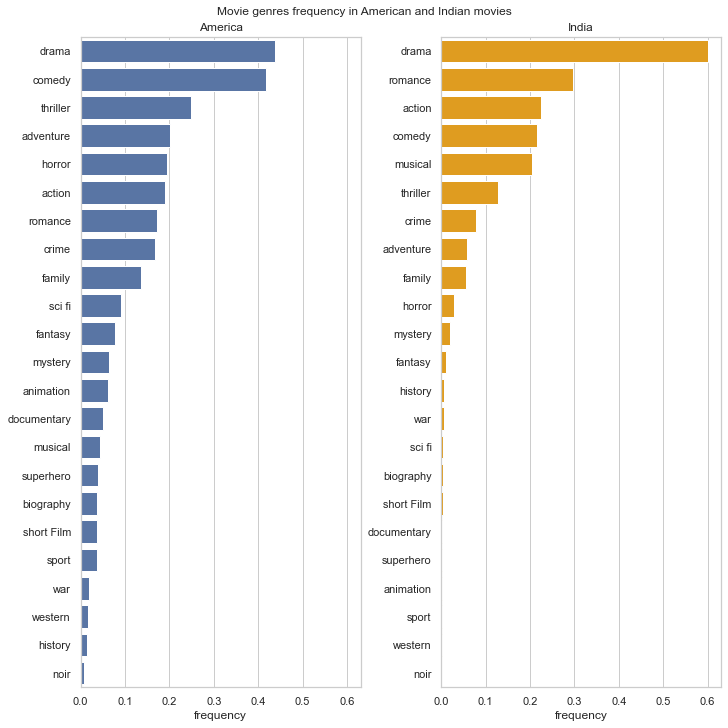

In [247]:
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in American and Indian movies')
ax[0].set_title('America')
ax[1].set_title('India')

sns.barplot(ax = ax[0],y = genres_american.index, x = genres_american['frequency'], label="American", color="b")
sns.barplot(ax = ax[1], y = genres_indian.index, x = genres_indian['frequency'], label="Indian", color="orange")
plt.show()

In [249]:
# running t-sne on the topics and actor data
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init = 'pca')
features_tsne = pd.DataFrame(tsne.fit_transform(pd.concat([features_indian_train.iloc[:,:23], features_american_train.iloc[:,:23]])), columns=['tsne1', 'tsne2'])
features_indian_tsne = features_tsne.iloc[:features_indian_train.shape[0], :].reset_index(drop=True)
features_american_tsne = features_tsne.iloc[features_indian_train.shape[0]:, :].reset_index(drop=True)

c:\Users\hugom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [250]:
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

username = 'lgburget' # your username
api_key = 'vWYUwXe1jfrskXgIuyVf' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [251]:
#we use dummies for the genres and non standardized values for actor data...
feats_indian = features_indian.copy().drop(columns=['movie_release_date', 'wikipedia_movie_id' ,'averageRating']).reset_index(drop=True)
feats_american = features_american.copy().drop(columns=['movie_release_date', 'wikipedia_movie_id' ,'averageRating']).reset_index(drop=True)

# ...and z-score for the topics prevalence
feats_indian.iloc[:,27:]=features_indian_train.iloc[:,27:]
feats_american.iloc[:,27:]=features_american_train.iloc[:,27:]

#features = pd.concat([feats_indian, feats_american]).reset_index(drop=True)
colors_country = np.append(np.repeat('orange', feats_indian.shape[0]), np.repeat('blue', feats_american.shape[0]))

In [261]:
genre='comedy'
n=4
colors = []
random.seed(0)

#generating random colors for the clusters
for i in range(n):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))

#running kmeans on the features from tsne
kmeans = KMeans(n_clusters=n, random_state=3).fit(features_tsne[features[genre]==1])

country = np.append(np.repeat(1, sum(feats_indian[genre]==1)) , np.repeat(0,sum(feats_american[genre]==1)))
cols=np.append(feats_indian.columns[23:], ['Indian', 'American'])

#finding movies with the corresponding genre
feats_topics = np.append(feats_indian[feats_indian[genre]==1].iloc[:,23:].values, feats_american[feats_american[genre]==1].iloc[:,23:].values, axis=0)
ratio_country = np.mean(country)

#computing the mean of each feature for each cluster
res = pd.DataFrame(np.zeros((n, len(cols))), columns=cols, dtype=float)
for i in range(n):
    res.iloc[i, :]=np.append(np.mean(feats_topics[kmeans.labels_==i, :], axis=0), [np.mean(country[kmeans.labels_==i]==1)/ratio_country, np.mean(country[kmeans.labels_==i]==0)/(1-ratio_country)])

res['percent_female_cast']*=100

#reshaping the dataframe for the plotly plot
res2 = pd.DataFrame({'cluster':np.array([np.repeat(i, res.shape[1]) for i in range(n)]).flatten().astype(int), 'feature':np.tile(res.columns, n).astype(str), 'value':res.values.flatten().astype(float)})

fig = go.Figure()

#adding the scatter plot
fig.add_scatter(x=features_tsne.loc[features[genre]==1, 'tsne1'], y=features_tsne.loc[features[genre]==1,'tsne2'], mode='markers', marker = dict(color = colors_country[features[genre]==1], size = 5), name='Country')

fig.update_layout(
    width=800,
    height=900,
    autosize=False,
    margin=dict(t=0, b=0, l=0, r=0),
    template="plotly_white",
)

#adding a button to switch between countries and kmeans coloring
fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=["marker", dict(color = colors_country[features[genre]==1], size = 5)],
                    label="Country",
                    method="restyle"
                ),
                dict(
                    args=["marker", dict(color=np.array(colors)[kmeans.labels_], size=5)],
                    label="KMeans",
                    method="restyle"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)

#adding an annotation
fig.update_layout(
    annotations=[
        dict(text="Color:", showarrow=False,
                             x=-50, y=1.08, yref="paper", align="left")
    ],
    title=dict(text=genre+ ' : t-SNE', x=0.5, y=0.97, xanchor='auto', yanchor='top', font=dict(size=30)),
)

fig.show()
#py.plot(fig, filename = genre +' TSNE', auto_open=True)

In [262]:
topics = ['experiment_scientist_power_creature', 'body_vampire_child_night', 'money_steal_prisoner_bank_drug', 'team_game_coach_player', 'ship_alien_earth_attack', 'murder_police_gang_fight_crime', 'agent_shoot_military_bomb', 'band_family_show_music_dream', 'family_father_mother_daughter_wedding', 'home_school_night_parent_party_decide', 'escape_camp_attack_truck', 'movie_woman_play_character_role']

fig = go.Figure()

#adding figures related to topics
for i in topics:
    fig.add_bar(x=res2.loc[res2['feature']==i, 'cluster'], y=res2.loc[res2['feature']==i, 'value'], marker_color=colors, name=i)
#adding figures related to countries
for i in ['Indian', 'American']:
    fig.add_bar(x=res2.loc[res2['feature']==i, 'cluster'], y=res2.loc[res2['feature']==i, 'value'], marker_color=colors, name=i, visible=False)
#adding features related to actor data
for i in res2['feature'][:4]:
    fig.add_bar(x=res2.loc[res2['feature']==i, 'cluster'], y=res2.loc[res2['feature']==i, 'value'], marker_color=colors, name=i, visible=False)

# creating buttons to interact with the plot
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Topics",
                     method="update",
                     args=[{"visible": list(np.append(np.repeat(True, 12), np.repeat(False, 6)))}]),
                dict(label="Countries",
                     method="update",
                     args=[{"visible": list(np.append(np.repeat(False, 12), np.append(np.repeat(True, 2), np.repeat(False, 4))))}]),
                dict(label="Actor data",
                     method="update",
                     args=[{"visible": list(np.append(np.repeat(False, 14), np.repeat(True, 4)))}]),
            ]),
        )
    ],
    barmode='group', title=dict(text=genre+ ' : topic, country and gender representation', x=0.5, y=0.97, xanchor='auto', yanchor='top', font=dict(size=30)))

fig.update_layout(showlegend=False)

fig.show()
#py.plot(fig, filename = genre + ' topic, country and gender representation', auto_open=True)

# Wordclouds

In this section we are interested in finding the words that occur the most often in the Indian and American romantic movies summaries and underlying the differences between the two countries. We use the same pre-processing steps as in the LDA topic detection analysis and then use the wordcloud library to plot the wordclouds.

In [254]:
genre='romance'

# filter indian and american summaries with only romantic films
indian_summaries_genre = summaries_indian.merge(features_indian[['wikipedia_movie_id', genre]], on = 'wikipedia_movie_id')
indian_summaries_genre = indian_summaries_genre[indian_summaries_genre[genre] == 1].drop(columns=genre)

american_summaries_genre = summaries_american.merge(features_american[['wikipedia_movie_id', genre]], on = 'wikipedia_movie_id')
american_summaries_genre = american_summaries_genre[american_summaries_genre[genre] == 1].drop(columns=genre)

In [255]:
# create a list of stopwords and add missing words ; we add the word 'film'
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'film'])
counter = CountVectorizer()

**NOTE:** We add the word 'film' to the stopwords list because it is present in many summaries and often used in sentences like 'The film is about...' and is not relevant to the context of the movie

In [256]:
def make_wordcloud(df, country):
    # Create bigram models for nlp
    words = list(sent_to_words(df['summaries']))
    global bigram 
    bigram = gensim.models.Phrases(words, min_count=15, threshold=100) # higher threshold fewer phrases.
    global bigram_mod 
    bigram_mod= gensim.models.phrases.Phraser(bigram)

    # Apply NLP pipeline : remove stopwords, make bigrams, lemmatize
    words = remove_stopwords(words)
    words = make_bigrams(words)
    words = lemmatization(words, allowed_postags=['NOUN', 'ADJ'])

    # create bag of words matrix
    count_matrix = counter.fit_transform((pd.Series(words, dtype = str)))
    feature_array = np.array(counter.get_feature_names_out())

    # average BOW for each word
    avg_count = np.mean(count_matrix, axis=0)
    w = {feature_array[i]: avg_count[0,i] for i in range(0, count_matrix.shape[1])}

    # generate the mask and color generator for wordcloud
    if (country=='india'):
        mask_ = np.array(Image.open('./img/india.png'))
        mask = np.array(list(map(lambda x: [255, 255, 255, 255] if x < 2 else [0,0,0,255] ,mask_.flatten())))
        mask = mask.reshape(mask_.shape[0], mask_.shape[1], 4)
        coloring = ImageColorGenerator(np.array(Image.open("./img/india_flag.jpg")))
    elif (country=='usa'):
        mask_ = np.array(Image.open('./img/usa.png'))
        mask = np.array(list(map(lambda x: [255, 255, 255, 255] if x == 1 else [0,0,0,255] ,mask_.flatten())))
        mask = mask.reshape(mask_.shape[0], mask_.shape[1], 4)
        coloring = ImageColorGenerator(np.array(Image.open("./img/usa_flag.jpg")))
    else:
        assert 1==0, 'country should be India or USA'
    
    # generate the wordcloud
    wordcloud = WordCloud(color_func = coloring, background_color="white", max_words = 300, width = 1000, height = 800, stopwords=STOPWORDS, mask=mask).generate_from_frequencies(w)
    
    return wordcloud.to_image()
    

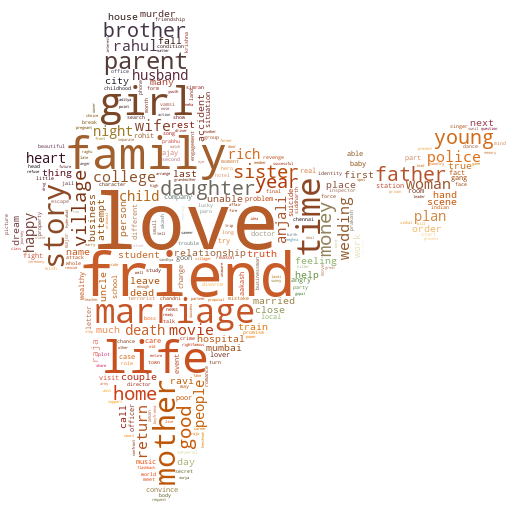

In [257]:
make_wordcloud(indian_summaries_genre, 'india')

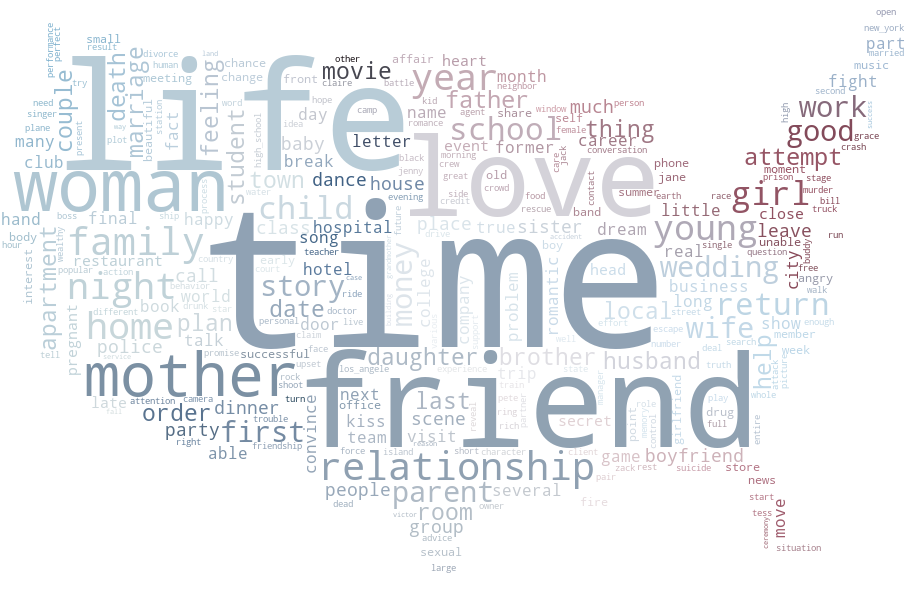

In [258]:
make_wordcloud(american_summaries_genre, 'usa')

**Note**: We notice that the notion of time is very important in American movies whereas it is not the case at all in India. It is also suprising to see that the word woman is more important than the word girl in the US whereas it is the opposite in India. This can maybe be put in perspective with what we observed in the previous section : the mean female actor age in American-dominated cluster of romantic movies is 33 years old whereas it is 27 years old in Indian-dominated clusters (6 years gap!). Moreover, the topics of family and marriage is also much more important in Indian romance than Americans.